Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1382/1382 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0030 - val_loss: 6.2856e-05
Epoch 2/100
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 2.1109e-04 - val_loss: 3.2242e-04
Epoch 3/100
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 1.4816e-04 - val_loss: 6.1896e-05
Epoch 4/100
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 1.1688e-04 - val_loss: 1.5060e-05
Epoch 5/100
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 9.4880e-05 - val_loss: 6.2953e-05
Epoch 6/100
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 1.0361e-04 - val_loss: 8.0171e-05
Epoch 7/100
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 1.0104e-04 - val_loss: 1.8716e-04
Epoch 8/100
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 1.0470e-04 - val_loss: 9.5401e-05
Epoch 9/100
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 8.2376e-05 - val_loss: 1.1217e-05
Epoch 10/100
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 9.0164e-05 - val_loss: 1.6710e-05
Epoch 11/100
1382/1382 ━━━━━━━━━━━

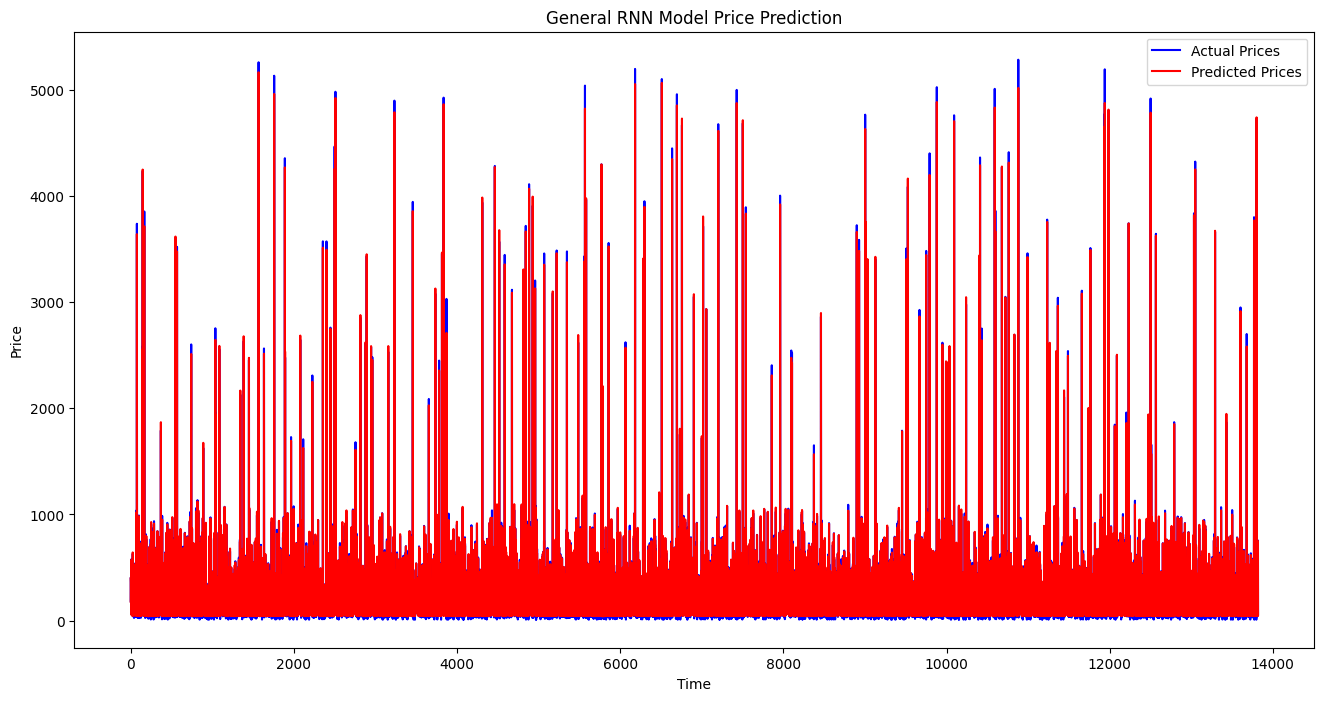

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Current price for AAPL: $212.69
Predicted next price for AAPL: $204.72
Trading decision: SELL
General model saved as general_rnn_model.h5
Scaler saved as scaler.pkl


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

def prepare_data_multi(df, sequence_length=60):
    """
    Prepare data from multiple symbols for a general RNN model.
    
    Parameters:
        df (pandas.DataFrame): Dataframe containing stock data.
        sequence_length (int): Number of previous days to use for prediction.
    
    Returns:
        tuple: (X_train, X_test, y_train, y_test, scaler)
    """
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df.sort_values(['Symbol', 'Date'])
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df[features].values)
    
    X, y = [], []
    symbols = df['Symbol'].unique()
    
    for sym in symbols:
        group = df[df['Symbol'] == sym].sort_values('Date')
        group_scaled = scaler.transform(group[features].values)
        
        for i in range(len(group_scaled) - sequence_length):
            X.append(group_scaled[i:i+sequence_length])
            y.append(group_scaled[i+sequence_length, 3])
    
    X, y = np.array(X), np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    return X_train, X_test, y_train, y_test, scaler

def create_rnn_model(input_shape):
    """
    Create an RNN model for stock price prediction.
    
    Parameters:
        input_shape (tuple): Shape of input data.
    
    Returns:
        model (tensorflow.keras.models.Sequential): RNN model.
    """
    model = Sequential([
        SimpleRNN(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        SimpleRNN(units=50, return_sequences=False),
        Dropout(0.2),
        
        Dense(units=25, activation='relu'),
        Dense(units=1)  # Predict the "Close" price
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

def train_model(X_train, y_train, epochs=50, batch_size=32):
    """
    Train the RNN model.
    """
    model = create_rnn_model(X_train.shape[1:])
    
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, X_test, y_test, scaler, features_shape):
    """
    Evaluate the model on test data.
    """
    predictions = model.predict(X_test)
    
    # Transform predictions and actual values
    dummy_pred = np.zeros((len(predictions), features_shape))
    dummy_pred[:, 3] = predictions.flatten()
    predictions_transformed = scaler.inverse_transform(dummy_pred)[:, 3]
    
    dummy_actual = np.zeros((len(y_test), features_shape))
    dummy_actual[:, 3] = y_test
    actual_transformed = scaler.inverse_transform(dummy_actual)[:, 3]
    
    # Calculate error metrics
    mse = np.mean((predictions_transformed - actual_transformed) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_transformed - actual_transformed))
    
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    
    # Calculate directional accuracy
    actual_direction = np.diff(actual_transformed, prepend=actual_transformed[0])[1:]
    predicted_direction = np.diff(predictions_transformed, prepend=predictions_transformed[0])[1:]
    correct_direction = (np.sign(actual_direction) == np.sign(predicted_direction)).sum()
    directional_accuracy = correct_direction / len(actual_direction) * 100
    
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")
    
    # Calculate buy/sell signal accuracy
    threshold = 0.01  # 1% change threshold
    actual_returns = actual_direction / actual_transformed[:-1]
    predicted_returns = predicted_direction / predictions_transformed[:-1]
    
    buy_signals = predicted_returns > threshold
    if buy_signals.sum() > 0:
        correct_buys = (actual_returns[buy_signals] > 0).sum()
        buy_accuracy = correct_buys / buy_signals.sum() * 100
        print(f"Buy Signal Accuracy: {buy_accuracy:.2f}% ({correct_buys}/{buy_signals.sum()})")
    else:
        print("No buy signals generated")
    
    sell_signals = predicted_returns < -threshold
    if sell_signals.sum() > 0:
        correct_sells = (actual_returns[sell_signals] < 0).sum()
        sell_accuracy = correct_sells / sell_signals.sum() * 100
        print(f"Sell Signal Accuracy: {sell_accuracy:.2f}% ({correct_sells}/{sell_signals.sum()})")
    else:
        print("No sell signals generated")
    
    trading_signals = np.logical_or(buy_signals, sell_signals)
    if trading_signals.sum() > 0:
        correct_trades = (actual_returns[buy_signals] > 0).sum() + (actual_returns[sell_signals] < 0).sum()
        trading_accuracy = correct_trades / trading_signals.sum() * 100
        print(f"Overall Trading Accuracy: {trading_accuracy:.2f}% ({correct_trades}/{trading_signals.sum()})")
    else:
        print("No trading signals generated")
    
    return predictions_transformed, actual_transformed

def plot_results(actual, predictions, title):
    """
    Plot actual vs predicted prices.
    """
    plt.figure(figsize=(16, 8))
    plt.plot(actual, color='blue', label='Actual Prices')
    plt.plot(predictions, color='red', label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def make_trading_decision(model, latest_data, scaler, threshold=0.01):
    """
    Make a trading decision based on the model's prediction.
    """
    latest_sequence = latest_data[-1:].reshape(1, latest_data.shape[1], latest_data.shape[2])
    
    next_price_scaled = model.predict(latest_sequence)[0, 0]
    current_price_scaled = latest_sequence[0, -1, 3]  # index 3 for "Close"
    
    dummy = np.zeros((1, latest_data.shape[2]))
    dummy[0, 3] = next_price_scaled
    next_price = scaler.inverse_transform(dummy)[0, 3]
    
    dummy[0, 3] = current_price_scaled
    current_price = scaler.inverse_transform(dummy)[0, 3]
    
    expected_return = (next_price - current_price) / current_price
    
    if expected_return > threshold:
        decision = 'buy'
    elif expected_return < -threshold:
        decision = 'sell'
    else:
        decision = 'hold'
    
    return decision, next_price, current_price

def main():
    # Read your dataset
    df = pd.read_csv('../data/updated_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Prepare data from all symbols
    X_train, X_test, y_train, y_test, scaler = prepare_data_multi(df, sequence_length=60)
    
    # Train the model
    model, history = train_model(X_train, y_train, epochs=100)
    
    # Evaluate the model on test data
    predictions, actual = evaluate_model(model, X_test, y_test, scaler, X_train.shape[2])
    
    plot_results(actual, predictions, "General RNN Model Price Prediction")
    
    # Example: Get trading decision for a specific symbol (e.g., AAPL)
    symbol = 'AAPL'
    symbol_df = df[df['Symbol'] == symbol].sort_values('Date')
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    latest_data = symbol_df[features].values[-60:]
    latest_data = scaler.transform(latest_data).reshape(1, 60, 5)
    
    decision, next_price, current_price = make_trading_decision(model, latest_data, scaler)
    print(f"Current price for {symbol}: ${current_price:.2f}")
    print(f"Predicted next price for {symbol}: ${next_price:.2f}")
    print(f"Trading decision: {decision.upper()}")

    model.save('general_rnn_model.h5')
    print("General model saved as general_rnn_model.h5")

    # Save the scaler
    joblib.dump(scaler, 'scaler.pkl')
    print("Scaler saved as scaler.pkl")

if __name__ == "__main__":
    main()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Current price for AAPL: $212.69
Predicted next price for AAPL: $203.94
Predicted price change: -4.11%
Trading Decision: SELL


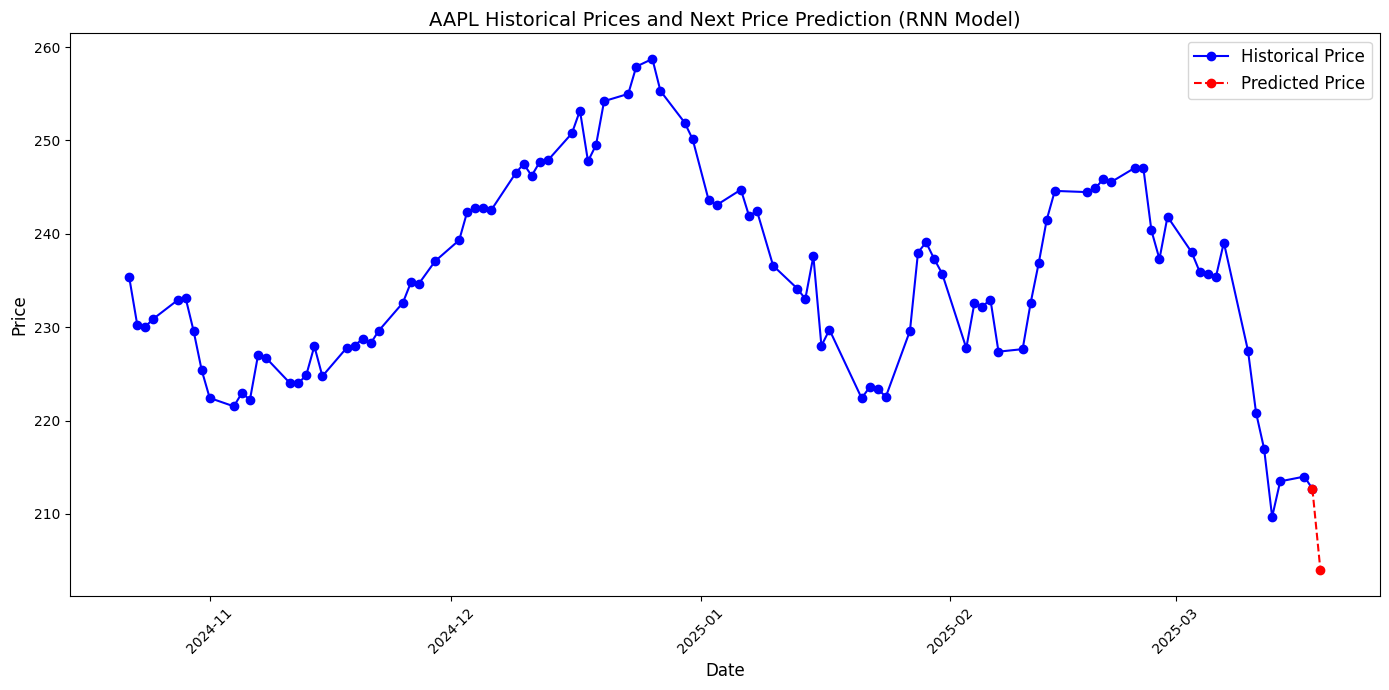

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# ---------------------------
# Load the trained model
# ---------------------------
model = load_model('../backend/models/general_rnn_model.h5')

# ---------------------------
# Load and prepare your dataset
# ---------------------------
# Update the path to your dataset as needed
df = pd.read_csv('../data/updated_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Choose the symbol you want to predict (e.g., AAPL)
symbol = 'AAPL'
symbol_df = df[df['Symbol'] == symbol].sort_values('Date')

# Define features as used during training
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Recreate the scaler – ideally you would have saved it along with your model.
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df[features].values)

# ---------------------------
# Create a sequence for prediction
# ---------------------------
sequence_length = 60
if len(symbol_df) < sequence_length:
    raise ValueError("Not enough data to form a sequence for prediction.")

# Use the last 'sequence_length' days for prediction
latest_data = symbol_df[features].values[-sequence_length:]
latest_data_scaled = scaler.transform(latest_data).reshape(1, sequence_length, len(features))

# ---------------------------
# Make a prediction
# ---------------------------
predicted_scaled = model.predict(latest_data_scaled)
predicted_scaled_value = predicted_scaled[0, 0]  # predicted "Close" price (scaled)

# To inverse transform, we create a dummy array with the correct shape and set the 'Close' column
dummy = np.zeros((1, len(features)))
dummy[0, 3] = predicted_scaled_value  # index 3 corresponds to 'Close'
predicted_price = scaler.inverse_transform(dummy)[0, 3]

# Current price for comparison
current_price = symbol_df['Close'].iloc[-1]
price_change_percentage = ((predicted_price - current_price) / current_price) * 100

print(f"Current price for {symbol}: ${current_price:.2f}")
print(f"Predicted next price for {symbol}: ${predicted_price:.2f}")
print(f"Predicted price change: {price_change_percentage:.2f}%")

# Determine trading decision
threshold = 0.01  # 1% change threshold
if price_change_percentage > threshold:
    decision = "BUY"
elif price_change_percentage < -threshold:
    decision = "SELL"
else:
    decision = "HOLD"
print(f"Trading Decision: {decision}")

# ---------------------------
# Plot the results with improved aesthetics
# ---------------------------
# Choose how many past days to display (if available)
n_days = 100
plot_data = symbol_df[-n_days:].copy()

# Prepare dates and prices for plotting
dates = plot_data['Date'].tolist()
actual_prices = plot_data['Close'].values

# Append next day (for prediction)
next_date = dates[-1] + pd.Timedelta(days=1)
dates.append(next_date)

plt.figure(figsize=(14, 7))

# Plot historical prices
plt.plot(dates[:-1], actual_prices, marker='o', linestyle='-', label='Historical Price', color='blue')

# Plot the predicted price as a dashed line from the last actual day to the predicted next day
plt.plot([dates[-2], dates[-1]], [actual_prices[-1], predicted_price],
         marker='o', linestyle='--', label='Predicted Price', color='red')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title(f'{symbol} Historical Prices and Next Price Prediction (RNN Model)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()